# Load libraries

Важно: Не успях директно да копирам kaggle.json файла и затова първо се свързвам към Google Drive. Ще трябва да промените работната си директория по-долу, ако ще ползвате този код.

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
mainDirectory = "/content/drive" + "/MyDrive/Google Colab" # Трябва да се смени това, ако подкарвате тетрадката във вашия драйв
# mainDirectory="/content/drive/MyDrive/Colab Notebooks/TF_Project"
fileName = mainDirectory + "/kaggle.json"

In [11]:
! mkdir ~/.kaggle
! cp "{fileName}" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
# Tensorflow utilities
!pip install -q tensorflow-addons
!pip install -q tensorflow-probability
!pip install -q tensorflow-io
!pip install -q tensorflow_extra

# Other utilies
!pip install -q opencv-python-headless
!pip install -q librosa
!pip install -q scikit-learn

# Kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import zipfile
import csv
import pandas as pd
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

#added
from random import random, randint,sample
from IPython.display import Audio
from IPython.core.display import display
import tensorflow_hub as hub
import sys
import math


import librosa
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Import for visualization
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd
import cv2

# Import tensorflow
import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)

# Import required tensorflow modules
import tensorflow_io as tfio
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import tensorflow_extra as tfe
import tensorflow.keras.backend as K
from keras.utils import plot_model

<ipython-input-13-2e6e6d64b553>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [14]:
! mkdir ./cache

mkdir: cannot create directory ‘./cache’: File exists


# Download and extract data

In [15]:
! kaggle competitions download birdclef-2023

100% 4.91G/4.91G [03:35<00:00, 24.3MB/s]
100% 4.91G/4.91G [03:35<00:00, 24.4MB/s]


In [16]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("birdclef-2023.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [17]:
!rm birdclef-2023.zip

In [18]:
!ls train_audio

abethr1  blaplo1  carcha1  fatrav1  hartur1  mouwag1  rehblu1  spmthr1	wheslf1
abhori1  blbpuf2  carwoo1  fatwid1  helgui   ndcsun2  rehwea1  spwlap1	whhsaw1
abythr1  blcapa2  categr   fislov1  hipbab1  nobfly1  reisee2  squher1	whihel1
afbfly1  blfbus1  ccbeat1  fotdro5  hoopoe   norbro1  rerswa1  strher	whrshr1
afdfly1  blhgon1  chespa1  gabgos2  huncis1  norcro1  rewsta1  strsee1	witswa1
afecuc1  blhher1  chewea1  gargan   hunsun2  norfis1  rindov   stusta1	wlwwar
affeag1  blksaw1  chibat1  gbesta1  joygre1  norpuf1  rocmar2  subbus1	wookin1
afgfly1  blnmou1  chtapa3  gnbcam2  kerspa2  nubwoo1  rostur1  supsta1	woosan
afghor1  blnwea1  chucis1  gnhsun1  klacuc1  pabspa1  ruegls1  tacsun1	wtbeat1
afmdov1  bltapa1  cibwar1  gobbun1  kvbsun1  palfly2  rufcha2  tafpri1	yebapa1
afpfly1  bltbar1  cohmar1  gobsta5  laudov1  palpri1  sacibi2  tamdov1	yebbar1
afpkin1  bltori1  colsun2  gobwea1  lawgol   piecro1  sccsun2  thrnig1	yebduc1
afpwag1  blwlap1  combul2  golher1  lesmaw1  piekin1  s

# Configuration

In [19]:
class CFG:
    # Random seed
    seed = 42

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 16
    participate_thr = 30 # min number of samples in order to participate in the sets
    upsample_thr = 50 # min sample of each class in training set (upsample)

    # Audio duration, sample rate, and length
    duration = 10 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    preferred_chunks = 1

    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True

    # Training and validation size
    train_proportion = 0.7
    test_validation_split_proportion = 0.7

    # Spectrogram output channels
    out_channels = 3

    # Number of epochs
    epochs = 16

    # Learning rate
    lr = 1e-4

    # Label smoothing
    label_smoothing = 0.05

    # Time Freq masking
    freq_mask_prob=0.50
    num_freq_masks=1
    freq_mask_param=10
    time_mask_prob=0.50
    num_time_masks=2
    time_mask_param=25

    # Audio Augmentation Settings
    noise_prob = 0.5
    min_std = 0.0025
    max_std = 0.025

    mixup_prob = 0.65
    mixup_alpha = 0.3

    cutmix_prob = 0.65
    cutmix_alpha = 1.5

In [20]:
tf.keras.utils.set_random_seed(CFG.seed)

# Explore the data

In [21]:
dirpaths = []

In [22]:
for dirpath, dirnames, filenames in os.walk("train_audio"):
    c = dirpath.split('/')
    if len(c) > 1:
        c = c[1]
    dirpaths.append((dirpath, len(filenames), c))
    # print(f"There are {len(dirnames)} directories and {len(filenames)} audio files in '{dirpath}'.")

In [23]:
dirpaths.sort(key=lambda x: x[1], reverse = True)


In [24]:
dirpaths[:10]

[('train_audio/wlwwar', 500, 'wlwwar'),
 ('train_audio/comsan', 500, 'comsan'),
 ('train_audio/eaywag1', 500, 'eaywag1'),
 ('train_audio/thrnig1', 500, 'thrnig1'),
 ('train_audio/barswa', 500, 'barswa'),
 ('train_audio/woosan', 486, 'woosan'),
 ('train_audio/combuz1', 477, 'combuz1'),
 ('train_audio/eubeat1', 437, 'eubeat1'),
 ('train_audio/hoopoe', 436, 'hoopoe'),
 ('train_audio/cohmar1', 425, 'cohmar1')]

In [25]:
metadata = pd.read_csv("train_metadata.csv")
metadata

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...
16936,yewgre1,[],[''],-1.2502,29.7971,Eurillas latirostris,Yellow-whiskered Greenbul,András Schmidt,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://xeno-canto.org/703472,yewgre1/XC703472.ogg
16937,yewgre1,[],[''],-1.2489,29.7923,Eurillas latirostris,Yellow-whiskered Greenbul,András Schmidt,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/703485,yewgre1/XC703485.ogg
16938,yewgre1,[],[''],-1.2433,29.7844,Eurillas latirostris,Yellow-whiskered Greenbul,András Schmidt,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/704433,yewgre1/XC704433.ogg
16939,yewgre1,[],[''],0.0452,36.3699,Eurillas latirostris,Yellow-whiskered Greenbul,Lars Lachmann,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/752974,yewgre1/XC752974.ogg


In [26]:
num_labels = len(metadata[['primary_label', 'common_name']].drop_duplicates())
num_labels

264

In [27]:
class2bird = metadata[['primary_label', 'common_name']].drop_duplicates().set_index('primary_label').to_dict()['common_name']

In [28]:
taxonomy = pd.read_csv("eBird_Taxonomy_v2021.csv")
taxonomy

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN
...,...,...,...,...,...,...,...,...,...
16748,34694,species,slcgro1,Slate-colored Grosbeak,Saltator grossus,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16749,34697,species,bltgro2,Black-throated Grosbeak,Saltator fuliginosus,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16750,34698,spuh,saltat1,saltator sp.,Saltator sp.,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16751,34699,spuh,passer1,passerine sp.,Passeriformes sp.,Passeriformes,NaN,Others,NaN


In [29]:
train_dirs = list(map(lambda x: x[0], dirpaths[:-1]))
train_dirs[:10]

['train_audio/wlwwar',
 'train_audio/comsan',
 'train_audio/eaywag1',
 'train_audio/thrnig1',
 'train_audio/barswa',
 'train_audio/woosan',
 'train_audio/combuz1',
 'train_audio/eubeat1',
 'train_audio/hoopoe',
 'train_audio/cohmar1']

In [30]:
dir_labels = list(map(lambda x: x[2], dirpaths[:-1]))
dir_labels = list(map(lambda x: class2bird[x], dir_labels))
dir_labels[:10]

['Willow Warbler',
 'Common Sandpiper',
 'Western Yellow Wagtail',
 'Thrush Nightingale',
 'Barn Swallow',
 'Wood Sandpiper',
 'Common Buzzard',
 'European Bee-eater',
 'Eurasian Hoopoe',
 'Common House-Martin']

In [31]:
train_files = []
train_labels = []
for i in range(len(dir_labels)):
    for dirpath, dirnames, filenames in os.walk(train_dirs[i]):
        train_files = train_files + list(map(lambda x: train_dirs[i] + '/' + x , filenames))
        train_labels = train_labels + len(filenames) * [dir_labels[i]]

In [32]:
train_files[400:410], train_labels[400:410]
# train_labels[np.where(train_labels =='Barn Swallow')]
# train_labels[1000:1010]

(['train_audio/wlwwar/XC728297.ogg',
  'train_audio/wlwwar/XC653712.ogg',
  'train_audio/wlwwar/XC431080.ogg',
  'train_audio/wlwwar/XC467781.ogg',
  'train_audio/wlwwar/XC416397.ogg',
  'train_audio/wlwwar/XC559231.ogg',
  'train_audio/wlwwar/XC236672.ogg',
  'train_audio/wlwwar/XC549554.ogg',
  'train_audio/wlwwar/XC531099.ogg',
  'train_audio/wlwwar/XC578420.ogg'],
 ['Willow Warbler',
  'Willow Warbler',
  'Willow Warbler',
  'Willow Warbler',
  'Willow Warbler',
  'Willow Warbler',
  'Willow Warbler',
  'Willow Warbler',
  'Willow Warbler',
  'Willow Warbler'])

## Creating label encoder for the bird labels

This is a necessary first step in order to create One-Hot Encoding Later. The inverse transform will be used to get the Label name from the corresponding number.

In [33]:
birds_label_encoder = LabelEncoder()

birds_label_encoder.fit(dir_labels)
birds_label_encoder.transform(dir_labels)

array([245,  74, 228, 221,  21, 247,  72,  89,  88,  73, 133,  71, 171,
        25, 111, 103, 183, 201,  70, 169,  29,  62, 220,  60,  85, 110,
        93,  95, 259, 235, 117,   2, 175, 164, 214, 186,  68,  31, 128,
       263, 255, 223,  13, 113, 222, 219, 114, 210, 163, 216,   6, 224,
        97,  14,  42,  56,  66,  79, 192, 236,  24, 257, 233,  10, 134,
       106, 176, 129, 195, 248,  55,  86,  53,  23, 211, 120, 180,   8,
       174, 127, 107, 165, 105, 196,  41,  77, 240, 212,   7, 172,  28,
       155, 194, 112,  17, 168,  18,  61, 204, 177, 206,  50, 144, 131,
        33,  47, 217, 148, 207,  76, 146, 250,  94,  22, 252, 227, 125,
       161,  59, 198, 190, 213, 145,  78, 208,   5, 147,  48, 199,  58,
       118,  12,  67, 132, 260,  45,  32, 244, 184, 100, 157,   0, 262,
       231,  65,  44, 116,  43,  90,  11, 191, 185, 153, 108,  20, 197,
        34, 232,  49, 251, 158,  30, 200, 187, 202, 152, 173,  82, 203,
       156, 154, 151,  37, 102, 115, 225, 241, 139, 249, 226,   

## Display audio and spectrogram

In [34]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

In [35]:
def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio,
                                   sr=CFG.sample_rate,
                                   n_mels=CFG.img_size[0],
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    return spec

In [36]:
def display_audio(filepath, label):
    # Caption
    caption = f'File: {filepath} | Bird label: {label}'
    # Read audio file
    audio, sr = load_audio(filepath)
    # Keep fixed length audio
    ### audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    # Display spectrogram
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                color= cmap(0.1))
    # Specplot
    lid.specshow(spec,
                 sr = CFG.sample_rate,
                 hop_length = CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time',
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

# Audio:


# Visualization:


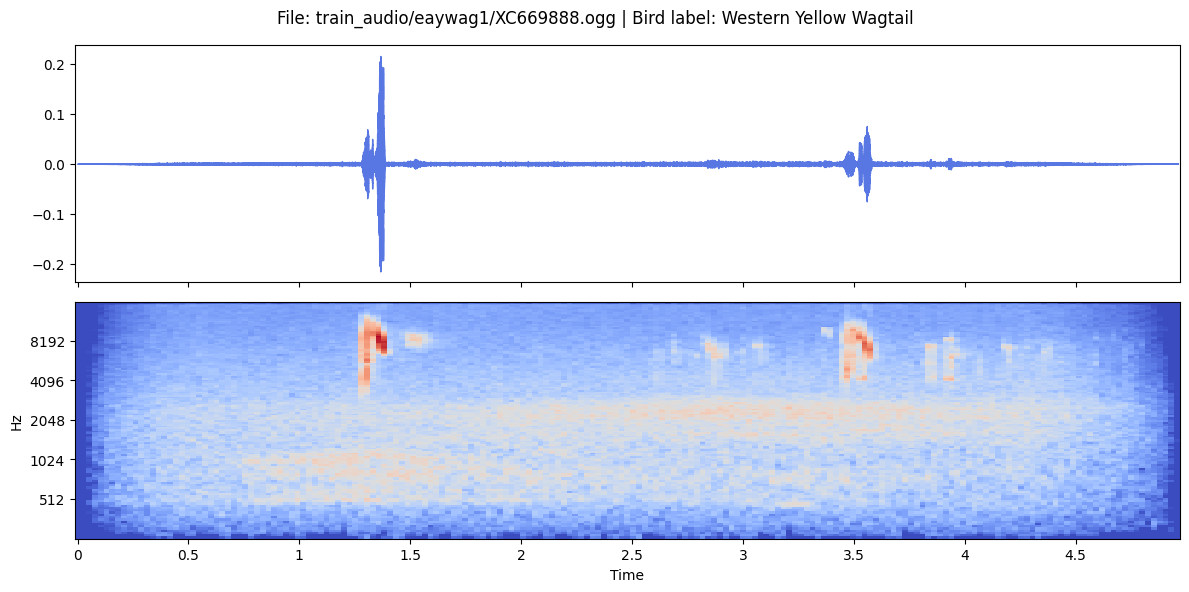

In [37]:
display_audio(train_files[1001], train_labels[1001])

# Create train and validation datasets

In [38]:
all_data = {"File": train_files,
            "Label": train_labels}
all_data = pd.DataFrame(all_data)

In [39]:
all_data = all_data.sort_values(by='File')
all_data = all_data.reset_index(drop=True)

In [40]:
all_data

,File,Label
0,train_audio/abethr1/XC128013.ogg,African Bare-eyed Thrush
1,train_audio/abethr1/XC363501.ogg,African Bare-eyed Thrush
2,train_audio/abethr1/XC363502.ogg,African Bare-eyed Thrush
3,train_audio/abethr1/XC363503.ogg,African Bare-eyed Thrush
4,train_audio/abethr1/XC363504.ogg,African Bare-eyed Thrush
...,...,...
16936,train_audio/yewgre1/XC703472.ogg,Yellow-whiskered Greenbul
16937,train_audio/yewgre1/XC703485.ogg,Yellow-whiskered Greenbul
16938,train_audio/yewgre1/XC704433.ogg,Yellow-whiskered Greenbul
16939,train_audio/yewgre1/XC752974.ogg,Yellow-whiskered Greenbul


## Encoding the Label

In [41]:
all_data.Label = birds_label_encoder.transform(all_data.Label)

In [42]:
all_data

,File,Label
0,train_audio/abethr1/XC128013.ogg,1
1,train_audio/abethr1/XC363501.ogg,1
2,train_audio/abethr1/XC363502.ogg,1
3,train_audio/abethr1/XC363503.ogg,1
4,train_audio/abethr1/XC363504.ogg,1
...,...,...
16936,train_audio/yewgre1/XC703472.ogg,263
16937,train_audio/yewgre1/XC703485.ogg,263
16938,train_audio/yewgre1/XC704433.ogg,263
16939,train_audio/yewgre1/XC752974.ogg,263


## Filtering labels with too few examples

There are some labels with only 1 file. We should make sure they are in the training data instead of the validation data.

In [43]:
def filter_data(df, thr=CFG.participate_thr):
    # Count the number of samples for each class
    counts = df.Label.value_counts()

    # Condition that selects classes with less than `thr` samples
    cond = df.Label.isin(counts[counts<thr].index.tolist())

    # Add a new column to select the samples that will be included
    df['Include'] = True

    # Set False for those class where there is samples less than thr
    df.loc[cond, 'Include'] = False

    # Return the filtered dataframe
    return df

The rows with `Validation=False` will participate only in the training data.

In [44]:
all_data = filter_data(all_data, thr=CFG.participate_thr)
# all_data = []
all_data

,File,Label,Include
0,train_audio/abethr1/XC128013.ogg,1,False
1,train_audio/abethr1/XC363501.ogg,1,False
2,train_audio/abethr1/XC363502.ogg,1,False
3,train_audio/abethr1/XC363503.ogg,1,False
4,train_audio/abethr1/XC363504.ogg,1,False
...,...,...,...
16936,train_audio/yewgre1/XC703472.ogg,263,True
16937,train_audio/yewgre1/XC703485.ogg,263,True
16938,train_audio/yewgre1/XC704433.ogg,263,True
16939,train_audio/yewgre1/XC752974.ogg,263,True


## Splitting train and validation sets

In [45]:
exclude_data = all_data[all_data.Include == False].drop(columns=["Include"])

In [46]:
unique, counts = np.unique(exclude_data.Label, return_counts=True)
print(unique)
print(counts)
exclude_data.Label.value_counts()[4]

[  0   1   3   4   9  11  15  16  19  20  26  27  30  32  34  35  36  37
  38  39  40  43  44  45  46  49  51  52  54  57  63  64  65  67  69  75
  80  81  82  83  84  87  90  91  92  96  98  99 100 101 102 104 108 109
 115 116 119 121 122 123 124 126 130 132 135 136 137 138 139 140 141 142
 143 149 150 151 152 153 154 156 157 158 159 160 162 166 167 170 173 178
 179 181 182 184 185 187 188 189 191 193 197 200 202 203 205 209 215 218
 225 226 229 230 231 232 234 237 238 239 241 242 243 244 246 249 251 253
 254 256 258 260 261 262]
[28 15 18  7  8 25  1  6 12 24 13  7 22 28 23 16 17 20 11  7 15 26 27 29
  3 22  2 10  1  9  6  8 27 29 13  1  3  8 21 15  9  7 25  5 15  5  3  2
 28 12 20 10 24  9 19 26 18  8 16  5  7  8 14 29 18 15  1  3 19  6 16 15
  6  8 16 20 21 24 20 20 28 22 14  4  7 10 14 17 21 12  9  2  5 28 25 22
 10  6 25  3 23 22 21 21 12 13  4  6 19 18 14 10 27 23  7  9  1 17 19  1
  8 28  5 19 22 17  1 13 12 29 15 27]


7

In [47]:
to_split_data = all_data[all_data.Include == True].drop(columns=["Include"])

In [48]:
unique, counts = np.unique(to_split_data.Label, return_counts=True)
print(len(unique))
print(counts)

132
[126  31  90  48  57  72  30 104  81  45  43 500  34  60  76 262  47 166
 109  38  50  81  38  30  40  62  67  81  30  34 153  43 166  79 113 181
 293 477 425 500  36  49  32  79 152  63 436 437 137  34 136  81 239  51
  72  53 138 252  45 103  94 129  30  59  34  56 109  68  40 378  72  40
  32  36  30  37  46  34  91 121  52  44 172 281  47  56 122  70  42  59
 227 116  33  78  45  68  51  33  30 199  42  41  37  32  94  59  48  33
 119  90  37  97 161 500  98 105  88  34 500  73 132  78  48 500 486  67
  35  34 106  75 134 108]


In [49]:
train_data, test_validation_data = train_test_split(to_split_data, train_size = CFG.train_proportion, random_state = CFG.seed, stratify = to_split_data.Label)
test_data, validation_data = train_test_split(test_validation_data, train_size = CFG.test_validation_split_proportion, random_state = CFG.seed, stratify = test_validation_data.Label)

In [50]:
# train_data = pd.concat([train_data,exclude_data])
train_data = train_data.reset_index(drop=True)

validation_data = validation_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [51]:
train_data

,File,Label
0,train_audio/cohmar1/XC713342.ogg,73
1,train_audio/thrnig1/XC740276.ogg,221
2,train_audio/yertin1/XC633675.ogg,259
3,train_audio/cibwar1/XC690370.ogg,68
4,train_audio/tafpri1/XC452376.ogg,220
...,...,...
10522,train_audio/wlwwar/XC181236.ogg,245
10523,train_audio/combul2/XC440111.ogg,71
10524,train_audio/eaywag1/XC543956.ogg,228
10525,train_audio/cohmar1/XC656615.ogg,73


In [52]:
validation_data

,File,Label
0,train_audio/afrthr1/XC253101.ogg,17
1,train_audio/chibat1/XC492740.ogg,66
2,train_audio/reccuc1/XC497376.ogg,175
3,train_audio/eubeat1/XC380979.ogg,89
4,train_audio/combul2/XC317498.ogg,71
...,...,...
1349,train_audio/whbcou1/XC599199.ogg,233
1350,train_audio/pitwhy/XC315024.ogg,165
1351,train_audio/comsan/XC431425.ogg,74
1352,train_audio/thrnig1/XC239956.ogg,221


In [53]:
test_data

,File,Label
0,train_audio/cohmar1/XC330725.ogg,73
1,train_audio/comsan/XC497331.ogg,74
2,train_audio/wbswea1/XC513745.ogg,236
3,train_audio/gycwar3/XC254667.ogg,105
4,train_audio/broman1/XC195341.ogg,47
...,...,...
3153,train_audio/didcuc1/XC750204.ogg,79
3154,train_audio/afpfly1/XC323329.ogg,13
3155,train_audio/gyhbus1/XC546620.ogg,106
3156,train_audio/combul2/XC443485.ogg,71


## Upsampling the training set

... To be done

In [54]:
def upsample_data(df, thr=CFG.upsample_thr):
    # get the class distribution
    class_dist = df['Label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df[df.Label == c]
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)

    return up_df

In [55]:
train_data = upsample_data(train_data, thr=CFG.upsample_thr)
train_data = shuffle(train_data, random_state=CFG.seed)
train_data = train_data.reset_index(drop=True)
train_data

,File,Label
0,train_audio/thrnig1/XC243986.ogg,221
1,train_audio/afrthr1/XC137936.ogg,17
2,train_audio/pitwhy/XC618477.ogg,165
3,train_audio/blakit1/XC115289.ogg,25
4,train_audio/yebbar1/XC287741.ogg,252
...,...,...
11783,train_audio/kerspa2/XC212518.ogg,125
11784,train_audio/meypar1/XC131621.ogg,145
11785,train_audio/yefcan/XC207920.ogg,257
11786,train_audio/tafpri1/XC609489.ogg,220


# Dataset functions

## Creating audio decoder function

In [56]:
def audio_decoder(with_labels = False, num_labels=264):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes) # decode .ogg file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1]>1: # stereo -> mono
            audio = audio[...,0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, num_labels), tf.float32)
        target = tf.reshape(target, [num_labels])
        return target

    def decode_with_labels(filepath, label):
        label = get_target(label)
        audio = get_audio(filepath)
        return (audio, label)

    def decode_without_labels(filepath):
        audio = get_audio(filepath)
        return (audio,)

    if with_labels:
        return decode_with_labels
    else:
        return decode_without_labels

In [57]:
audio_decoder(with_labels = True)(train_files[0], birds_label_encoder.transform([train_labels[0]]))

(<tf.Tensor: shape=(5147585,), dtype=float32, numpy=
 array([ 1.2433625e-07, -3.7258742e-06, -1.0103809e-06, ...,
         8.8074503e-06, -1.0965432e-05,  2.7243050e-05], dtype=float32)>,
 <tf.Tensor: shape=(264,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

## Creating pad or crop transform

In [58]:
def crop_or_pad(with_labels = False, crop = True, target_len = CFG.audio_len, preferred_chunks = CFG.preferred_chunks, pad_mode='constant'):
    def crop_or_pad_audio(audio, label = None):
        audio_len = tf.shape(audio)[0]
        min_preferred_len = target_len * preferred_chunks
        if crop:
            chunks = tf.TensorArray(tf.float32, size = preferred_chunks, element_shape=[target_len])
            index = 0
            if audio_len <= min_preferred_len:
                parsed_len = 0
                while parsed_len < audio_len:
                    end_len = parsed_len + target_len
                    if end_len <= audio_len:
                        chunks = chunks.write(index, audio[parsed_len:end_len])
                    else:
                        diff_len = end_len - audio_len
                        chunk = tf.pad(audio[parsed_len:audio_len], paddings=[[0, diff_len]], mode=pad_mode)
                        chunks = chunks.write(index, chunk)
                    index += 1
                    parsed_len = end_len
            else:
                sector_len = audio_len // preferred_chunks
                diff_len = sector_len - target_len
                for i in tf.range(preferred_chunks):
                    shift = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
                    left = sector_len * i + shift
                    right = left + target_len
                    chunk = audio[left:right]
                    chunks = chunks.write(index, chunk)
                    index += 1
            if label is None:
                return chunks.gather(tf.range(index))
            else:
                labels = tf.broadcast_to(label, [index, label.shape[0]])
                return chunks.gather(tf.range(index)), labels
        else:
            audio = tf.reshape(audio, [-1])
            if label is None:
                return [audio]
            else:
                return [audio], [label]

    def crop_or_pad_with_labels(audio, label):
        chunks, labels = crop_or_pad_audio(audio, label)
        return tf.data.Dataset.from_tensor_slices((chunks, labels))

    def crop_or_pad_without_labels(audio):
        chunks = crop_or_pad_audio(audio)
        return tf.data.Dataset.from_tensor_slices((chunks,))

    if with_labels:
        return crop_or_pad_with_labels
    else:
        return crop_or_pad_without_labels

In [59]:
def create_spectrogram(with_labels = False, out_channels = 1):
    def create_spectrogram_from_audio(audio):
        spectrogram = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                                n_fft=CFG.nfft,
                                                hop_length=CFG.hop_length,
                                                sr=CFG.sample_rate,
                                                ref=1.0,
                                                out_channels=out_channels)(audio)
        return spectrogram

    def create_spectrogram_with_labels(audio, label):
        spectrogram = create_spectrogram_from_audio(audio)
        return (spectrogram, label)

    def create_spectrogram_without_labels(audio):
        spectrogram = create_spectrogram_from_audio(audio)
        return (spectrogram,)

    if with_labels:
        return create_spectrogram_with_labels
    else:
        return create_spectrogram_without_labels

In [60]:
def apply_noise(with_labels = False, min_std = CFG.min_std, max_std = CFG.max_std, prob = CFG.noise_prob):
    def add_noise(audio):
        # Select a random value of standard deviation for Gaussian noise within the given range
        std = tf.random.uniform(shape=[], minval = min_std, maxval = max_std, dtype=tf.float32)
        rand = tf.random.uniform(shape=[], minval = 0, maxval = 1, dtype=tf.float32)
        # Randomly apply Gaussian noise with probability `prob`
        if rand < prob:
            # Add random Gaussian noise to the audio signal
            GN = tf.keras.layers.GaussianNoise(stddev=std)
            audio = GN(audio, training=True) # training = False don't apply noise to data
        return audio

    def apply_noise_with_labels(audio, label):
        audio = add_noise(audio)
        return audio, label

    def apply_noise_without_labels(audio):
        audio = add_noise(audio)
        return audio

    if with_labels:
        return apply_noise_with_labels
    else:
        return apply_noise_without_labels


In [61]:
mixup_layer = tfe.layers.MixUp(alpha=CFG.mixup_alpha, prob=CFG.mixup_prob)
cutmix_layer = tfe.layers.CutMix(alpha=CFG.cutmix_alpha, prob=CFG.cutmix_prob)

def MixUp(audios, labels):
    audios, labels = mixup_layer(audios, labels, training=True)
    return audios, labels

def CutMix(audios, labels):
    audios, labels = cutmix_layer(audios, labels, training=True)
    return audios, labels

## Creating the datasets

In [62]:
def build_dataset(paths, labels = None, num_labels = 264, repeat = False, shuffle = False, crop = True, batch = True, add_noise = False, add_mixup = False, add_cutmix = False, cache = False, cache_index = '1', target_len = CFG.audio_len, pad_mode='constant', preferred_chunks = CFG.preferred_chunks, batch_size = CFG.batch_size, drop_remainder = False):
    with_labels = labels is not None

    # Set TensorFlow AUTOTUNE option
    AUTO = tf.data.experimental.AUTOTUNE
    # Build the dataset
    if with_labels:
        dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((paths,))
    # Map the file names to the actual audio and the labels to the One-Hot encoding
    dataset = dataset.map(audio_decoder(with_labels = with_labels, num_labels = num_labels), num_parallel_calls=AUTO)
    # Crop or pad the audios so they have the same length and can be batched
    dataset = dataset.flat_map(crop_or_pad(with_labels = with_labels, crop = crop, target_len = target_len, pad_mode = pad_mode, preferred_chunks = preferred_chunks))
    # Shuffle if the option is enabled
    if shuffle:
        dataset = dataset.shuffle(shuffle, seed=CFG.seed)
    # Batch the dataset with the specified batch size
    if batch:
        dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    # Cache the data for better performance
    if cache:
        dataset = dataset.cache(filename=('./cache/audio' + cache_index))
    # Repeat if the option is enabled
    if repeat:
        dataset = dataset.repeat()
    # Add Gaussian noise if enabled pad
    if add_noise:
        dataset = dataset.map(apply_noise(with_labels = with_labels, min_std = CFG.min_std, max_std = CFG.max_std, prob = CFG.noise_prob), num_parallel_calls=AUTO)
    # Add MixUp if enabled
    if add_mixup and labels is not None:
        dataset = dataset.map(MixUp, num_parallel_calls=AUTO)
    # Add CutMix if enabled
    if add_cutmix and labels is not None:
        dataset = dataset.map(CutMix, num_parallel_calls=AUTO)
    # Prefetch the data for better performance
    dataset = dataset.prefetch(buffer_size=AUTO)

    return dataset

In [63]:
### train_dataset = build_dataset(train_data.File, train_data.Label, num_labels = num_labels,
###                               repeat = True, shuffle = True, crop = True, batch = True,
###                               add_noise = True, add_mixup = True, add_cutmix = True,
###                               cache = True, cache_index = '_train', preferred_chunks = CFG.preferred_chunks)
validation_dataset = build_dataset(validation_data.File, validation_data.Label, num_labels = num_labels, repeat = False, shuffle = False, crop = True, batch = True, cache = True, cache_index = '_validation')
test_dataset = build_dataset(test_data.File, None, num_labels = num_labels, repeat = False, shuffle = False, crop = False, batch = False, cache = False)

In [64]:
### print("Training example:")
### for x in train_dataset.take(1):
###    print(x)

print("\nValidation example:")
for x in validation_dataset.take(1):
    print(x)

print("\nTesting example:")
for x in test_dataset.take(1):
    print(x)


Validation example:
(<tf.Tensor: shape=(16, 320000), dtype=float32, numpy=
array([[-3.0113559e-04, -2.2874987e-03, -8.3457597e-04, ...,
        -3.2519496e-03, -2.6798507e-03,  2.3638655e-04],
       [ 3.8264312e-03,  2.8255284e-03,  1.6270707e-03, ...,
        -5.4846267e-04, -1.2196417e-03, -2.4756719e-03],
       [ 1.8372748e-03,  1.0157599e-03, -8.8399742e-04, ...,
        -2.0196573e-04, -2.3895585e-04, -3.2964631e-04],
       ...,
       [ 6.2463768e-03,  5.1841140e-03,  1.3250450e-03, ...,
        -6.7479913e-03, -8.3979350e-03, -8.0007063e-03],
       [-1.6886164e-03, -8.5634721e-04, -9.8798797e-04, ...,
         1.7863481e-03,  2.5111630e-03,  3.8540969e-04],
       [ 6.4204214e-06,  1.0980189e-06, -5.8293472e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)>, <tf.Tensor: shape=(16, 264), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0

# Siamese model

## Creating Training data triplets

In [65]:
train_data

,File,Label
0,train_audio/thrnig1/XC243986.ogg,221
1,train_audio/afrthr1/XC137936.ogg,17
2,train_audio/pitwhy/XC618477.ogg,165
3,train_audio/blakit1/XC115289.ogg,25
4,train_audio/yebbar1/XC287741.ogg,252
...,...,...
11783,train_audio/kerspa2/XC212518.ogg,125
11784,train_audio/meypar1/XC131621.ogg,145
11785,train_audio/yefcan/XC207920.ogg,257
11786,train_audio/tafpri1/XC609489.ogg,220


In [66]:
siamese_train_data = train_data
siamese_train_data = siamese_train_data.rename(columns={"File" : "Anchor"})
siamese_train_data.head(10)

,Anchor,Label
0,train_audio/thrnig1/XC243986.ogg,221
1,train_audio/afrthr1/XC137936.ogg,17
2,train_audio/pitwhy/XC618477.ogg,165
3,train_audio/blakit1/XC115289.ogg,25
4,train_audio/yebbar1/XC287741.ogg,252
5,train_audio/woosan/XC282045.ogg,247
6,train_audio/barswa/XC496624.ogg,21
7,train_audio/blakit1/XC695515.ogg,25
8,train_audio/litegr/XC188332.ogg,133
9,train_audio/tamdov1/XC641205.ogg,219


In [67]:
siamese_train_data['Positive'] = siamese_train_data.apply(lambda x : siamese_train_data[siamese_train_data['Label'] == x['Label']].loc[siamese_train_data['Anchor']!=x['Anchor']].sample(1)['Anchor'].iloc[0],axis=1)
siamese_train_data
siamese_train_data['Negative'] = siamese_train_data.apply(lambda x : siamese_train_data[siamese_train_data['Label'] != x['Label']].sample(1)['Anchor'].iloc[0],axis=1)
siamese_train_data

,Anchor,Label,Positive,Negative
0,train_audio/thrnig1/XC243986.ogg,221,train_audio/thrnig1/XC243724.ogg,train_audio/piekin1/XC471025.ogg
1,train_audio/afrthr1/XC137936.ogg,17,train_audio/afrthr1/XC431270.ogg,train_audio/soufis1/XC433630.ogg
2,train_audio/pitwhy/XC618477.ogg,165,train_audio/pitwhy/XC618470.ogg,train_audio/cohmar1/XC556858.ogg
3,train_audio/blakit1/XC115289.ogg,25,train_audio/blakit1/XC206107.ogg,train_audio/chibat1/XC686532.ogg
4,train_audio/yebbar1/XC287741.ogg,252,train_audio/yebbar1/XC156617.ogg,train_audio/eaywag1/XC675673.ogg
...,...,...,...,...
11783,train_audio/kerspa2/XC212518.ogg,125,train_audio/kerspa2/XC18468.ogg,train_audio/spepig1/XC442988.ogg
11784,train_audio/meypar1/XC131621.ogg,145,train_audio/meypar1/XC424537.ogg,train_audio/barswa/XC496382.ogg
11785,train_audio/yefcan/XC207920.ogg,257,train_audio/yefcan/XC552095.ogg,train_audio/grewoo2/XC601586.ogg
11786,train_audio/tafpri1/XC609489.ogg,220,train_audio/tafpri1/XC507935.ogg,train_audio/comsan/XC370350.ogg


In [68]:
# number of rows where anchor == positive
siamese_train_data[siamese_train_data.Positive == siamese_train_data.Anchor]

,Anchor,Label,Positive,Negative


In [69]:
siamese_train_data

,Anchor,Label,Positive,Negative
0,train_audio/thrnig1/XC243986.ogg,221,train_audio/thrnig1/XC243724.ogg,train_audio/piekin1/XC471025.ogg
1,train_audio/afrthr1/XC137936.ogg,17,train_audio/afrthr1/XC431270.ogg,train_audio/soufis1/XC433630.ogg
2,train_audio/pitwhy/XC618477.ogg,165,train_audio/pitwhy/XC618470.ogg,train_audio/cohmar1/XC556858.ogg
3,train_audio/blakit1/XC115289.ogg,25,train_audio/blakit1/XC206107.ogg,train_audio/chibat1/XC686532.ogg
4,train_audio/yebbar1/XC287741.ogg,252,train_audio/yebbar1/XC156617.ogg,train_audio/eaywag1/XC675673.ogg
...,...,...,...,...
11783,train_audio/kerspa2/XC212518.ogg,125,train_audio/kerspa2/XC18468.ogg,train_audio/spepig1/XC442988.ogg
11784,train_audio/meypar1/XC131621.ogg,145,train_audio/meypar1/XC424537.ogg,train_audio/barswa/XC496382.ogg
11785,train_audio/yefcan/XC207920.ogg,257,train_audio/yefcan/XC552095.ogg,train_audio/grewoo2/XC601586.ogg
11786,train_audio/tafpri1/XC609489.ogg,220,train_audio/tafpri1/XC507935.ogg,train_audio/comsan/XC370350.ogg


## Helper functions for dataset

### Crop or pad for single 10sec snapshot

In [70]:
def crop_or_pad_siamese(with_labels = False, crop = True, pad = True, target_len = CFG.audio_len, pad_mode='constant', take_first = False):
    def crop_or_pad_audio(audio):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(target_len - audio_len)
        if audio_len < target_len and pad:
            audio = tf.pad(audio, paddings=[[0, diff_len]], mode=pad_mode)
        elif audio_len > target_len and crop:
            if take_first:
                audio = audio[:target_len]
            else:
                idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
                audio = audio[idx: (idx + target_len)]
        return tf.reshape(audio, [-1])

    def crop_or_pad_triplet_with_labels(anchor,positive,negative,label):
        anch_audio = crop_or_pad_audio(anchor)
        pos_audio = crop_or_pad_audio(positive)
        neg_audio = crop_or_pad_audio(negative)
        return ([anch_audio,pos_audio,neg_audio],label)

    def crop_or_pad_triplet_without_labels(anchor,positive,negative):
        anch_audio = crop_or_pad_audio(anchor)
        pos_audio = crop_or_pad_audio(positive)
        neg_audio = crop_or_pad_audio(negative)
        return ([anch_audio,pos_audio,neg_audio],)

    if with_labels:
        return crop_or_pad_triplet_with_labels
    else:
        return crop_or_pad_triplet_without_labels

### Audio decoder

In [71]:
def audio_decoder_siamese(with_labels = False, num_labels=264):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes) # decode .ogg file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1]>1: # stereo -> mono
            audio = audio[...,0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, num_labels), tf.float32)
        target = tf.reshape(target, [num_labels])
        return target

    def triplet_decode_with_labels(anchor,positive,negative, label):
        anch_audio = get_audio(anchor)
        pos_audio = get_audio(positive)
        neg_audio = get_audio(negative)
        # label = get_target(label)
        return (anch_audio,pos_audio,neg_audio,label)

    def triplet_decode_without_labels(anchor,positive,negative):
        anch_audio = get_audio(anchor)
        pos_audio = get_audio(positive)
        neg_audio = get_audio(negative)
        return (anch_audio,pos_audio,neg_audio,)

    if with_labels:
        return triplet_decode_with_labels
    else:
        return triplet_decode_without_labels

### Audio noise

In [72]:
def apply_noise_siamese(with_labels = False, min_std = CFG.min_std, max_std = CFG.max_std, prob = CFG.noise_prob):
    def add_noise(audio):
        # Select a random value of standard deviation for Gaussian noise within the given range
        std = tf.random.uniform(shape=[], minval = min_std, maxval = max_std, dtype=tf.float32)
        rand = tf.random.uniform(shape=[], minval = 0, maxval = 1, dtype=tf.float32)
        # Randomly apply Gaussian noise with probability `prob`
        if rand < prob:
            # Add random Gaussian noise to the audio signal
            GN = tf.keras.layers.GaussianNoise(stddev=std)
            audio = GN(audio, training=True) # training = False don't apply noise to data
        return audio

    def apply_noise_triplet_with_labels(anchor,positive,negative,label):
        anch_audio=add_noise(anchor)
        pos_audio=add_noise(positive)
        neg_audio=add_noise(negative)
        return [anch_audio,pos_audio,neg_audio],label

    def apply_noise_triplet_without_labels(anchor,positive,negative):
        anch_audio=add_noise(anchor)
        pos_audio=add_noise(positive)
        neg_audio=add_noise(negative)
        return [anch_audio,pos_audio,neg_audio]

    if with_labels:
        return apply_noise_triplet_with_labels
    else:
        return apply_noise_triplet_without_labels


In [73]:
def apply_noise(with_labels = False, min_std = CFG.min_std, max_std = CFG.max_std, prob = CFG.noise_prob):
    def add_noise(audio):
        # Select a random value of standard deviation for Gaussian noise within the given range
        std = tf.random.uniform(shape=[], minval = min_std, maxval = max_std, dtype=tf.float32)
        rand = tf.random.uniform(shape=[], minval = 0, maxval = 1, dtype=tf.float32)
        # Randomly apply Gaussian noise with probability `prob`
        if rand < prob:
            # Add random Gaussian noise to the audio signal
            GN = tf.keras.layers.GaussianNoise(stddev=std)
            audio = GN(audio, training=True) # training = False don't apply noise to data
        return audio

    def apply_noise_with_labels(audio, label):
        audio = add_noise(audio)
        return audio, label

    def apply_noise_without_labels(audio):
        audio = add_noise(audio)
        return audio

    if with_labels:
        return apply_noise_with_labels
    else:
        return apply_noise_without_labels

### Permute Function

In [74]:
def permute(X,y):
  X_t = tf.transpose(X, perm=[1,0,2])
  return X_t,y

## Dataset builder

In [75]:
def build_dataset_siamese(anchor,positive,negative, labels = None, num_labels = 264,
                  repeat = False, shuffle = False, crop = True, pad = True, batch = True,
                  add_noise = False,cache = False,
                  cache_index = '1', target_len = CFG.audio_len,pad_mode='constant',
                  batch_size = CFG.batch_size, drop_remainder = False):
    with_labels = labels is not None

    # Set TensorFlow AUTOTUNE option
    AUTO = tf.data.experimental.AUTOTUNE
    # Build the dataset
    if with_labels:
        dataset = tf.data.Dataset.from_tensor_slices((anchor,positive,negative, labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((anchor,positive,negative,))
    # Map the file names to the actual audio and the labels to the One-Hot encoding
    dataset = dataset.map(audio_decoder_siamese(with_labels = with_labels, num_labels = num_labels), num_parallel_calls=AUTO)
    # Crop or pad the audios so they have the same length and can be batched
    dataset = dataset.map(crop_or_pad_siamese(with_labels = with_labels,pad = pad, crop = crop, target_len = target_len, pad_mode = pad_mode), num_parallel_calls=AUTO)
    # Shuffle if the option is enabled
    if shuffle:
        dataset = dataset.shuffle(shuffle, seed=CFG.seed)
    # Batch the dataset with the specified batch size
    if batch:
        dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    # Cache the data for better performance
    if cache:
        dataset = dataset.cache(filename=('./cache/audio' + cache_index))
    # Repeat if the option is enabled
    if repeat:
        dataset = dataset.repeat()
    # Add Gaussian noise if enabled
    if add_noise:
        dataset = dataset.map(apply_noise(with_labels = with_labels, min_std = CFG.min_std, max_std = CFG.max_std, prob = CFG.noise_prob), num_parallel_calls=AUTO)

    # (batch_size,3,320000) -> (3,batch_size,320000)
    # dataset = dataset.map(permute)

    # Prefetch the data for better performance
    dataset = dataset.prefetch(buffer_size=AUTO)

    return dataset

## Create dataset for training

In [76]:
siamese_train_dataset = build_dataset_siamese(siamese_train_data.Anchor,siamese_train_data.Positive,siamese_train_data.Negative,
                              siamese_train_data.Label, num_labels = num_labels,
                              repeat = True, shuffle = True, crop = True,pad = True, batch = True,
                              add_noise = True, cache = True, cache_index = '_train')


In [77]:
print("Training example:")
for x in siamese_train_dataset.take(1):
    print(x[0].shape)
    print(x[1].shape)

Training example:
(16, 3, 320000)
(16,)


## Model creation

In [78]:
def cosine_distance(x,y):
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    distance = 1 - K.batch_dot(x, y, axes=-1)
    return distance

def triplet_loss(templates, margin=0.4):

    anchor,positive,negative = templates

    positive_distance = cosine_distance(anchor,positive)
    negative_distance = cosine_distance(anchor,negative)

    basic_loss = positive_distance-negative_distance+margin
    loss = K.maximum(basic_loss,0.0)

    return loss
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

In [79]:
def siamese_network(model,CFG = CFG):

  input = tf.keras.layers.Input(shape=(3,CFG.audio_len,), name="Input")
  audios = tf.reshape(input, [-1, input.shape[2]])
  results = model(audios)

  results = tf.keras.activations.softmax(results)
  results = tf.reshape(results, [-1, input.shape[1], num_labels])
  anchor = results[:,0,:]
  positive = results[:,1,:]
  negative = results[:,2,:]

  loss = tf.keras.layers.Lambda(triplet_loss)([anchor,positive,negative])

  siamese = tf.keras.models.Model(inputs=input, outputs=loss, name="Siamese-network")

  siamese.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=CFG.lr),
                  loss = identity_loss)
  return siamese,model

Model: "model_10__EFF2GRU_CNNGRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_effnetmodel (InputLaye  [(None, 320000)]    0           []                               
 r)                                                                                               
                                                                                                  
 mel_spectrogram_effnetmodel (M  (None, 128, 384, 3)  0          ['input_1_effnetmodel[0][0]']    
 elSpectrogram)                                                                                   
                                                                                                  
 z_score_min_max_effnetmodel (Z  (None, 128, 384, 3)  0          ['mel_spectrogram_effnetmodel[0][
 ScoreMinMax)                                                    0]']      

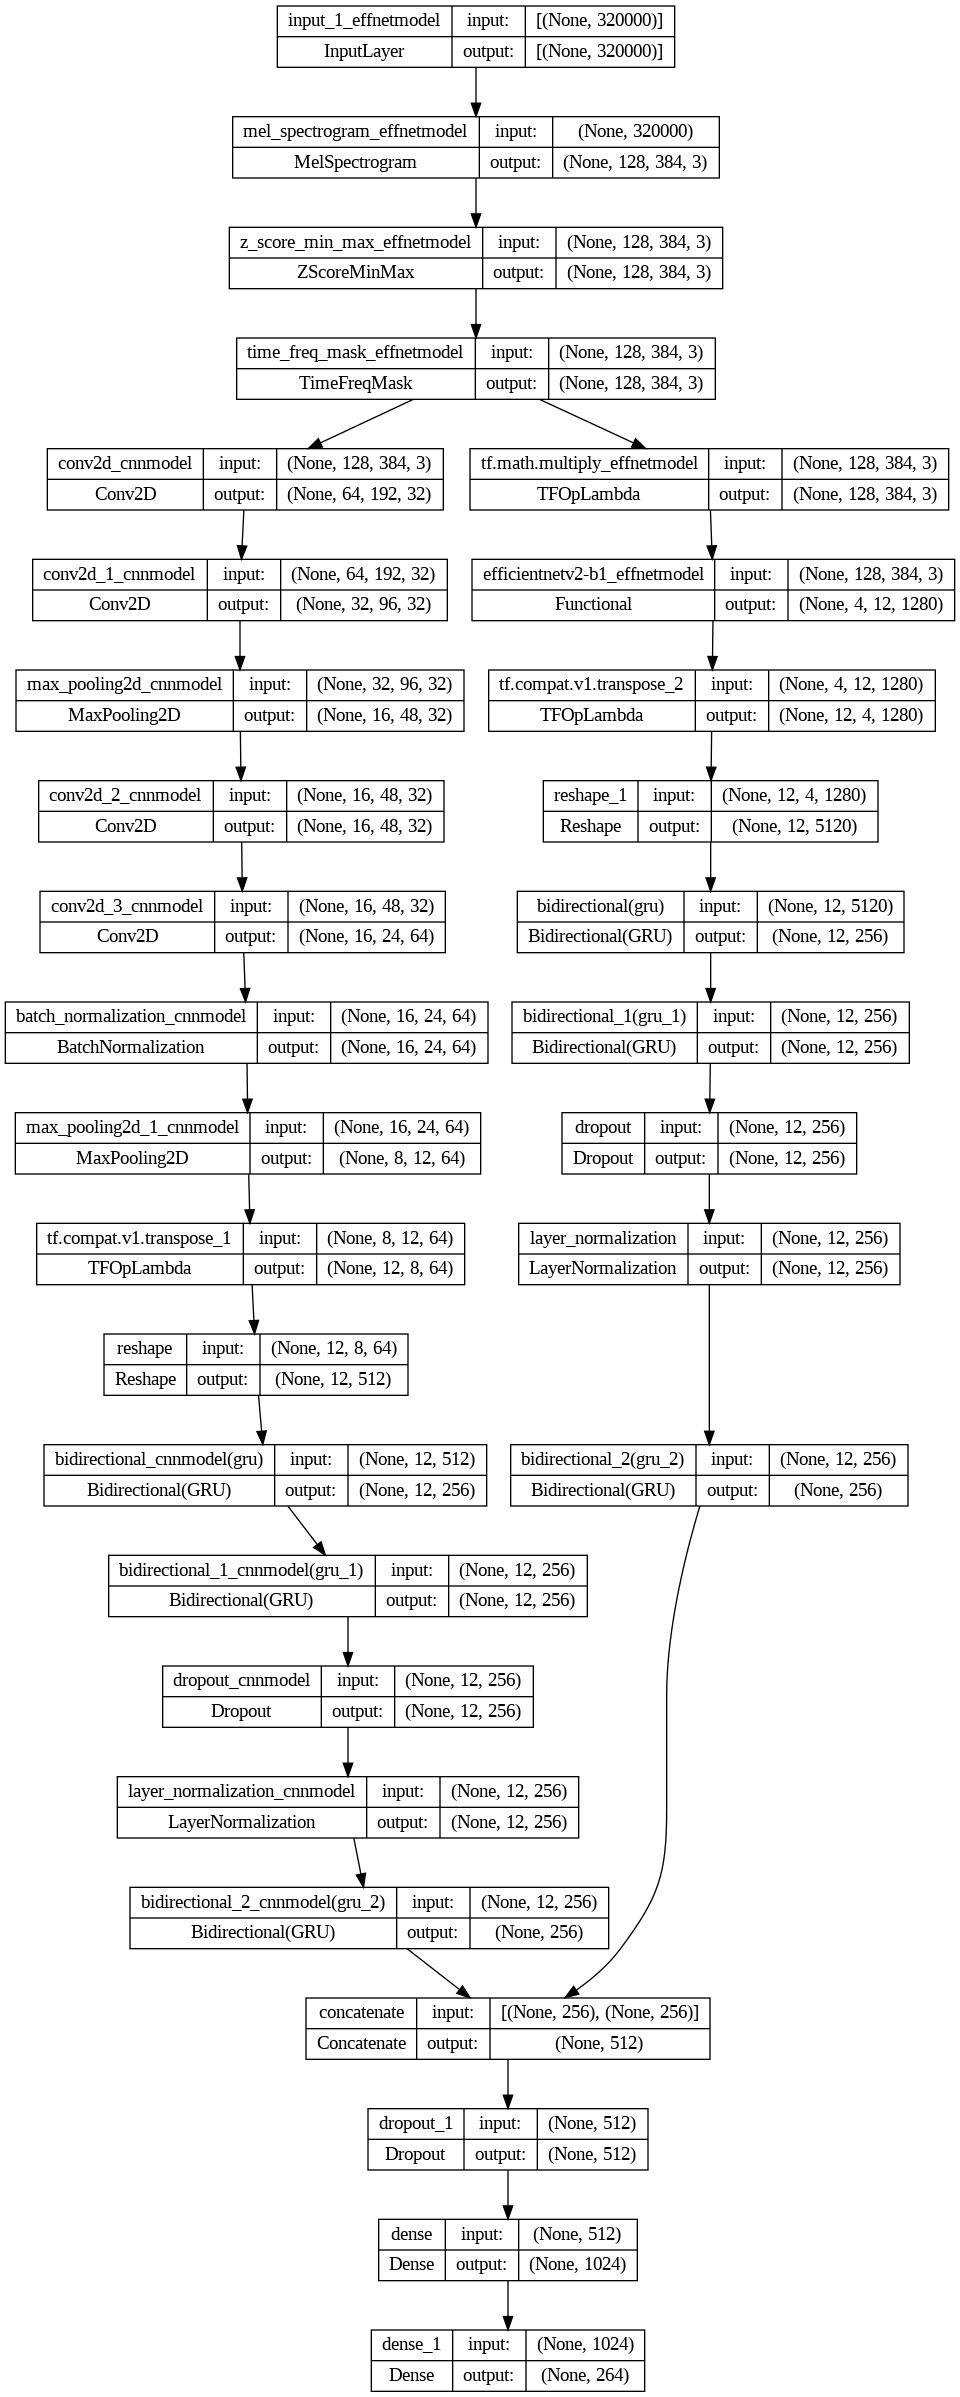

In [80]:
# get pretrained model
modelpath = mainDirectory + "/Model10/Full"
model = tf.keras.models.load_model(modelpath)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "Siamese-network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 3, 320000)]  0           []                               
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 320000)       0           ['Input[0][0]']                  
                                                                                                  
 model_10__EFF2GRU_CNNGRU (Func  (None, 264)         14961020    ['tf.reshape[0][0]']             
 tional)                                                                                          
                                                                                                  
 tf.nn.softmax (TFOpLambda)     (None, 264)          0           ['model_10__EFF2GRU

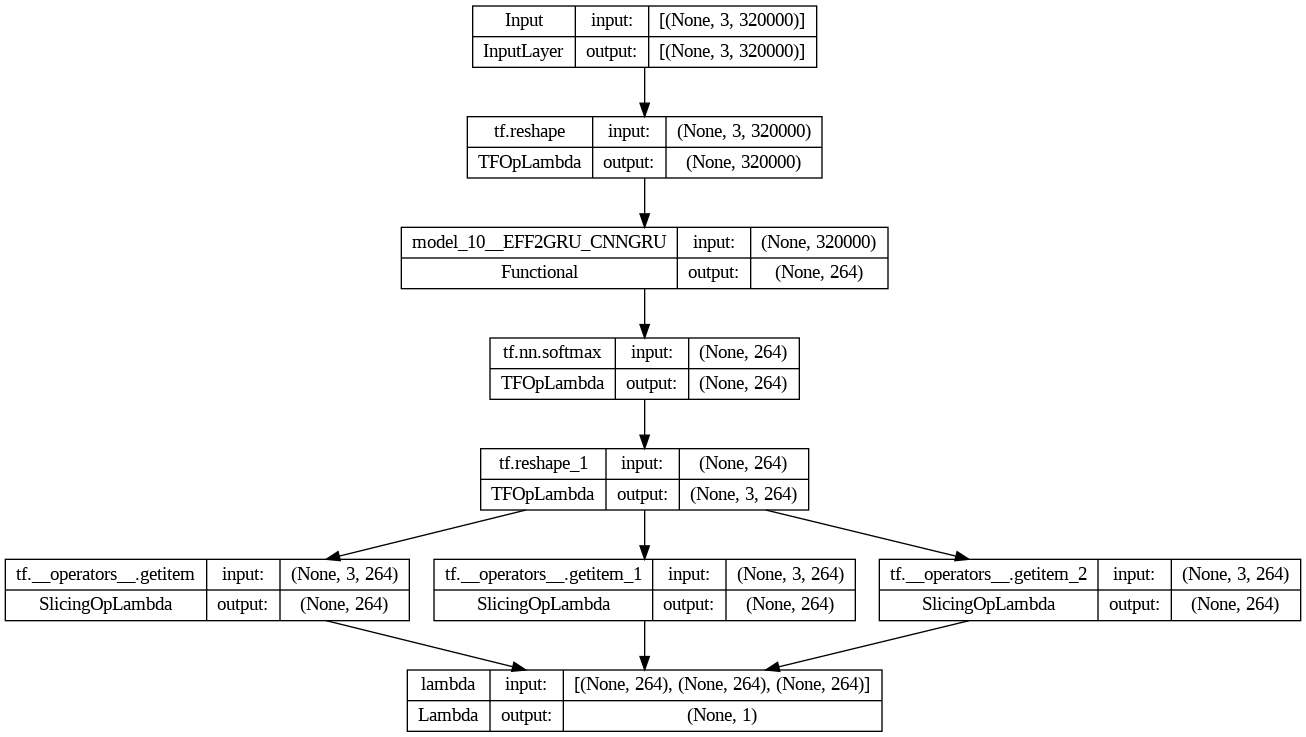

In [81]:
# create siamese network
siamese,model = siamese_network(model)
siamese.summary()
plot_model(siamese, show_shapes=True, show_layer_names=True)

## Model Training

In [82]:
training_history = siamese.fit(siamese_train_dataset,
                               epochs=CFG.epochs,
                               batch_size=CFG.batch_size,
                               steps_per_epoch=int(len(siamese_train_data)/CFG.batch_size))

Epoch 1/16
736/736 [==============================] - 2491s 3s/step - loss: 0.0750
Epoch 2/16
736/736 [==============================] - 483s 648ms/step - loss: 0.0675
Epoch 3/16
736/736 [==============================] - 477s 648ms/step - loss: 0.0636
Epoch 4/16
736/736 [==============================] - 477s 648ms/step - loss: 0.0575
Epoch 5/16
736/736 [==============================] - 476s 646ms/step - loss: 0.0477
Epoch 6/16
736/736 [==============================] - 477s 648ms/step - loss: 0.0468
Epoch 7/16
736/736 [==============================] - 476s 647ms/step - loss: 0.0432
Epoch 8/16
736/736 [==============================] - 477s 648ms/step - loss: 0.0444
Epoch 9/16
736/736 [==============================] - 477s 648ms/step - loss: 0.0419
Epoch 10/16
736/736 [==============================] - 476s 647ms/step - loss: 0.0379
Epoch 11/16
736/736 [==============================] - 477s 648ms/step - loss: 0.0385
Epoch 12/16
736/736 [==============================] - 476s 647ms

# Save the model

In [83]:
saveName = mainDirectory + "/Model10_Siamese"
model.save(saveName)

# Load the model if necessary

In [ ]:
loadName = mainDirectory + "/Model10_Siamese"
# model = tf.keras.models.load_model(loadName)
model.summary()

# Creating comparison vectors for making predictions

In [85]:
vectorsSaveDirectory = mainDirectory + "/Model10_Siamese/Vectors"

In [86]:
vectors = []
bird_labels = []
index = 0
for batch in siamese_train_dataset.take(int((len(siamese_train_data)+CFG.batch_size-1)/CFG.batch_size)):
    if index % 20 == 0:
        print("Index " + str(index))
    index += 1
    inputs = batch[0][:,0,:]
    labels = batch[1].numpy()
    outputs = model(inputs).numpy()
    outputs = tf.nn.softmax(outputs)
    vectors.extend([outputs[i] for i in range(outputs.shape[0])])
    bird_labels.extend(labels.tolist())

vectors = np.array(vectors)
bird_labels = np.array(bird_labels)

Index 0
Index 20
Index 40
Index 60
Index 80
Index 100
Index 120
Index 140
Index 160
Index 180
Index 200
Index 220
Index 240
Index 260
Index 280
Index 300
Index 320
Index 340
Index 360
Index 380
Index 400
Index 420
Index 440
Index 460
Index 480
Index 500
Index 520
Index 540
Index 560
Index 580
Index 600
Index 620
Index 640
Index 660
Index 680
Index 700
Index 720


In [ ]:
vectors_df = pd.DataFrame(vectors)
labels_df = pd.DataFrame(bird_labels)

vectors_df.to_csv(vectorsSaveDirectory + "/vectors.csv", index=False)
labels_df.to_csv(vectorsSaveDirectory + "/labels.csv", index=False)

# Making predictions

## Load the precalculated comparison vectors if necessary

In [ ]:
vectorsLoadDirectory = mainDirectory + "/Model10_Siamese/Vectors"

# vectors_df = pd.read_csv(vectorsLoadDirectory + "/vectors.csv")
# labels_df = pd.read_csv(vectorsLoadDirectory + "/labels.csv")
# vectors = np.array(vectors_df)
# bird_labels = np.array(labels_df)
# bird_labels = bird_labels.squeeze(1)

## Normalizing the comparison vectors

In [ ]:
normalized_vectors = vectors / np.linalg.norm(vectors, axis = 1)[:,np.newaxis]
normalized_vectors

## Create average vectors by label

Normally the mean vectors should have a norm of 1. For some labels there is no vectors and it doesn't make sense to have a mean vector. We will give them a value of (3,3,...,3) so they are far enough from the unit hyper-circle and don't outmatch the distances from the real mean vectors.

In [90]:
def create_mean_normalized_vectors(vectors, labels):
    mean_normalized_vectors = np.zeros(shape=(num_labels, vectors.shape[1]))
    for i in range(num_labels):
        labeled_vectors = vectors[labels == i]
        if labeled_vectors.shape[0] > 0:
            mean_normalized_vectors[i] = np.mean(labeled_vectors, axis = 0)
            mean_normalized_vectors[i] = mean_normalized_vectors[i] / np.linalg.norm(mean_normalized_vectors[i])
        else:
            mean_normalized_vectors[i] = 3 * np.ones(shape=(vectors.shape[1]))

    return mean_normalized_vectors

In [91]:
mean_normalized_vectors = create_mean_normalized_vectors(vectors, bird_labels)
print(mean_normalized_vectors.shape)
mean_normalized_vectors

(264, 264)


array([[3.00000000e+00, 3.00000000e+00, 3.00000000e+00, ...,
        3.00000000e+00, 3.00000000e+00, 3.00000000e+00],
       [3.00000000e+00, 3.00000000e+00, 3.00000000e+00, ...,
        3.00000000e+00, 3.00000000e+00, 3.00000000e+00],
       [1.78540237e-06, 1.81628285e-06, 9.95345583e-01, ...,
        2.46817523e-06, 1.76991125e-06, 8.12332372e-04],
       ...,
       [3.00000000e+00, 3.00000000e+00, 3.00000000e+00, ...,
        3.00000000e+00, 3.00000000e+00, 3.00000000e+00],
       [3.00000000e+00, 3.00000000e+00, 3.00000000e+00, ...,
        3.00000000e+00, 3.00000000e+00, 3.00000000e+00],
       [3.31954676e-05, 3.35710013e-05, 1.25878830e-02, ...,
        3.44772357e-05, 2.80062063e-05, 9.83249476e-01]])

## Creating helper functions for splitting audio and making predictions

In [92]:
def split_audio(audio, chunk_len = CFG.audio_len, pad_mode = 'constant'):
      chunks = []
      audio_len = tf.shape(audio)[0]
      parsed_len = 0
      while parsed_len < audio_len:
          end_len = parsed_len + chunk_len
          if end_len <= audio_len:
               chunks.append(audio[parsed_len:end_len])
          else:
              diff_len = end_len - audio_len
              chunk = tf.pad(audio[parsed_len:audio_len], paddings=[[0, diff_len]], mode=pad_mode)
              chunks.append(chunk)
          parsed_len = end_len

      return tf.data.Dataset.from_tensor_slices((chunks,))

In [93]:
def predict_vectors(model, dataset):
    results = []
    test_index = 0
    for x in dataset:
        chunks = split_audio(x[0])
        chunks = chunks.batch(CFG.batch_size)
        if test_index % 100 == 0:
          print("Index " + str(test_index))
        pred = model.predict(chunks, verbose = 0)
        pred = tf.nn.softmax(pred)
        results.append(pred)
        test_index += 1
    return results

## Making the test vectors predictions

In [94]:
results = predict_vectors(model, test_dataset)

Index 0
Index 100
Index 200
Index 300
Index 400
Index 500
Index 600
Index 700
Index 800
Index 900
Index 1000
Index 1100
Index 1200
Index 1300
Index 1400
Index 1500
Index 1600
Index 1700
Index 1800
Index 1900
Index 2000
Index 2100
Index 2200
Index 2300
Index 2400
Index 2500
Index 2600
Index 2700
Index 2800
Index 2900
Index 3000
Index 3100


In [ ]:
print(results[0])

## Implementing calculation of cosine distances

In [ ]:
def calculate_distances(targets, results):
    targets = targets
    num_results = len(results)
    distances = np.zeros(shape=(num_results, targets.shape[0]))
    for i in range(num_results):
        average_vector = np.mean(results[i], axis=0)
        average_vector = average_vector / np.linalg.norm(average_vector)
        average_vector = average_vector[np.newaxis,:]
        distances[i] = np.sum(np.power((targets - average_vector), 2), axis=1)

    return distances

## Implemeting transformation of distance to desirability score

Greater score for a label means that it is more preferred. We use a transformations that preserves the relative order of desirability, exact values are not important.

In [ ]:
def mean_vectors_distances_desirability(distances):
    desirabilities = 1 / (distances + 0.00000001)
    return desirabilities

In [ ]:
def knn_desirability(distances, labels, k=30):
    desirabilities = np.zeros(shape=(distances.shape[0], num_labels))
    closest_indices = np.argpartition(distances, k, axis = 1)
    for i in range(distances.shape[0]):
        for j in range(k):
            desirabilities[i][labels[closest_indices[i][j]]] += 1

    return desirabilities

## Implementing different metrics

In [ ]:
def get_accuracy(predictions, real):
    num_predictions = predictions.shape[0]
    predicted_classes = np.argmax(predictions, axis = 1)
    correct = np.sum(predicted_classes == real)

    return correct / num_predictions

In [ ]:
def get_top_k_accuracy(predictions, real, k = 5):
    num_predictions = predictions.shape[0]
    top_classes = np.argpartition(predictions, -k, axis = 1)
    correct = 0
    for i in range(num_predictions):
        correct += real[i] in top_classes[i][-k:]

    return correct / num_predictions

In [ ]:
def get_mistake_statistic(predictions, real):
    num_predictions = predictions.shape[0]
    predicted_classes = np.argmax(predictions, axis = 1)
    statistic = {"Name": np.arange(num_labels),
                 "Correct": np.zeros(num_labels, dtype=int),
                 "Mistaken": np.zeros(num_labels, dtype=int),
                 "All": np.zeros(num_labels, dtype=int),
                 "Percent correct": np.zeros(num_labels, dtype=float),
                 "Percent mistaken": np.zeros(num_labels, dtype=float)}
    statistic = pd.DataFrame(statistic)
    statistic.Name = birds_label_encoder.inverse_transform(statistic.Name)

    for i in range(real.shape[0]):
        statistic.loc[real[i], "All"] += 1
        statistic.loc[real[i], "Correct"] += predicted_classes[i] == real[i]

    statistic["Mistaken"] = statistic["All"] - statistic["Correct"]

    for i in range(statistic.shape[0]):
        if statistic.All[i] > 0:
            statistic.loc[i, "Percent correct"] = statistic.Correct[i] / statistic.All[i]
        else:
            statistic.loc[i, "Percent correct"] = 1.0

    statistic["Percent mistaken"] = 1 - statistic["Percent correct"]

    return statistic

In [ ]:
def calculate_results(predictions, y_real):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        predictions: predicted labels in the form of a 1D array
        y_real: true labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    y_pred = np.argmax(predictions, axis = 1)

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_real, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_real, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}

    return model_results

In [103]:
def show_performance(mean_normalized_vectors, normalized_vectors, test_data, bird_labels, results):
    distances_to_mean_vectors = calculate_distances(mean_normalized_vectors, results)
    distances_to_vectors = calculate_distances(normalized_vectors, results)

    mean_vectors_desirabilities = mean_vectors_distances_desirability(distances_to_mean_vectors)
    knn_desirabilities = knn_desirability(distances_to_vectors, bird_labels)

    statistic_mean = get_mistake_statistic(mean_vectors_desirabilities, test_data.Label)
    statistic_knn = get_mistake_statistic(knn_desirabilities, test_data.Label)

    statistic_mean = get_mistake_statistic(mean_vectors_desirabilities, test_data.Label)
    statistic_knn = get_mistake_statistic(knn_desirabilities, test_data.Label)

    print("Using KNN")
    df = pd.DataFrame(calculate_results(knn_desirabilities, test_data.Label), index=[0])
    print(df)
    print("Top 5 accuracy is: ", get_top_k_accuracy(knn_desirabilities, test_data.Label, 5))
    print("Classes with most mistakes")
    print(statistic_knn.sort_values("Mistaken", ascending=False)[["Name", "Mistaken", "All", "Percent mistaken"]].head(10))

    print("Using mean vectors")
    df = pd.DataFrame(calculate_results(mean_vectors_desirabilities, test_data.Label), index=[0])
    print(df)
    print("Top 5 accuracy is: ", get_top_k_accuracy(mean_vectors_desirabilities, test_data.Label, 5))
    print("Classes with most mistakes")
    print(statistic_mean.sort_values("Mistaken", ascending=False)[["Name", "Mistaken", "All", "Percent mistaken"]].head(10))

## Show statistics

In [104]:
show_performance(mean_normalized_vectors, normalized_vectors, test_data, bird_labels, results)

Using KNN
    accuracy  precision    recall        f1
0  75.775807   0.769826  0.757758  0.754321
Top 5 accuracy is:  0.8518049398353388
Classes with most mistakes
                        Name  Mistaken  All  Percent mistaken
21              Barn Swallow        22  105          0.209524
73       Common House-Martin        19   90          0.211111
235  White-browed Robin-Chat        18   28          0.642857
111              Great Egret        18   53          0.339623
95                  Garganey        17   29          0.586207
93        Fork-tailed Drongo        16   29          0.551724
220     Tawny-flanked Prinia        14   34          0.411765
71             Common Bulbul        13   62          0.209677
210   Spotted Morning-Thrush        13   20          0.650000
103  Gray-backed Camaroptera        12   50          0.240000
Using mean vectors
    accuracy  precision    recall        f1
0  75.142495   0.782163  0.751425  0.757095
Top 5 accuracy is:  0.8771374287523749
Classes 